# Proyecto de IA con Scikit.learn con Python
Crear un modelo de regresión y/o SVM y/o DT (Decission Tree) con la librería Scikit-learn siguiendo el ejemplo visto en clase.

## Preparación previa del entorno
Importamos las librerías necesarias

In [1]:
# Importamos las librerias necesarias
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm, tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline

import pickle

# Configuración para visualizaciones
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [10, 6]

## 1. Cargamos el dataset
En este ejemplo he elegido un dataset para predecir el consumo de energía.

[Energy Consumption Prediction](https://www.kaggle.com/datasets/mrsimple07/energy-consumption-prediction)  

In [2]:
# Cargamos los datos y los mostramos
df = pd.read_csv('../datasets/Energy_consumption.csv')
print(len(df))
df.head()

1000


,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


In [3]:
# Vemos los tipos de datos que contiene el dataset, 
# para poder tratarlos posteriormente
df.dtypes

Timestamp             object
Temperature          float64
Humidity             float64
SquareFootage        float64
Occupancy              int64
HVACUsage             object
LightingUsage         object
RenewableEnergy      float64
DayOfWeek             object
Holiday               object
EnergyConsumption    float64
dtype: object

## 2. Preparación de los datos

Vemos la descripción estadística del dataset

In [4]:
df.describe()

,Temperature,Humidity,SquareFootage,Occupancy,RenewableEnergy,EnergyConsumption
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,24.982026,45.395412,1500.052488,4.581000,15.132813,77.055873
std,2.836850,8.518905,288.418873,2.865598,8.745917,8.144112
min,20.007565,30.015975,1000.512661,0.000000,0.006642,53.263278
25%,22.645070,38.297722,1247.108548,2.000000,7.628385,71.544690
50%,24.751637,45.972116,1507.967426,5.000000,15.072296,76.943696
75%,27.418174,52.420066,1740.340165,7.000000,22.884064,82.921742
max,29.998671,59.969085,1999.982252,9.000000,29.965327,99.201120


Comprobamos que no haya nulos en el dataset

In [5]:
# Comprobamos si en nuestro dataset, existen valores nulos
# En este caso no contiene
def print_cols_with_missing_values(df):
    cols_with_missing = df.isnull().sum()
    print(cols_with_missing[cols_with_missing > 0])

print_cols_with_missing_values(df)

Series([], dtype: int64)


Borramos la columna Timestamp

In [6]:
# Borramos la columna "Timestamp", ya que no es relevante 
df = df.drop(['Timestamp'], axis=1)
df.head()

,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


## 3. Ingeniería de propiedades

In [7]:
# Almacenamos las columnas numéricas y categóricas en dos variables
# para poder tratarlas posteriormente
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(include=[object]).columns

print('Columnas numéricas:', numeric_cols)
print('Columnas categóricas:', categorical_cols)

Columnas numéricas: Index(['Temperature', 'Humidity', 'SquareFootage', 'Occupancy',
       'RenewableEnergy', 'EnergyConsumption'],
      dtype='object')
Columnas categóricas: Index(['HVACUsage', 'LightingUsage', 'DayOfWeek', 'Holiday'], dtype='object')


Vemos la distribución de los datos de tipo numérico

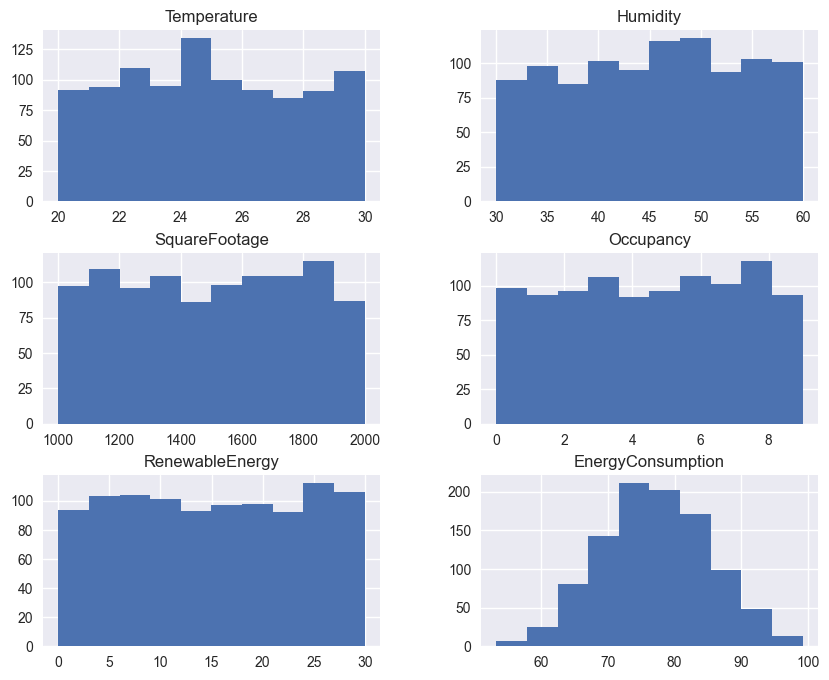

In [8]:
# Vemos la distribución de las columnas numéricas
df[numeric_cols].hist(figsize=(10, 8))
plt.show()

Convertimos los datos categoricos a numéricos

In [9]:
# Convertimos los valores categóricos a numéricos
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    
df[categorical_cols].head()


,HVACUsage,LightingUsage,DayOfWeek,Holiday
0,1,0,1,0
1,1,1,2,0
2,0,0,3,0
3,0,1,6,0
4,1,0,0,0


## 4. Importancia de propiedades y división del conjunto de datos

En este mapa de calor podemos las correlaciones entre las diferentes variables de nuestro conjunto de datos

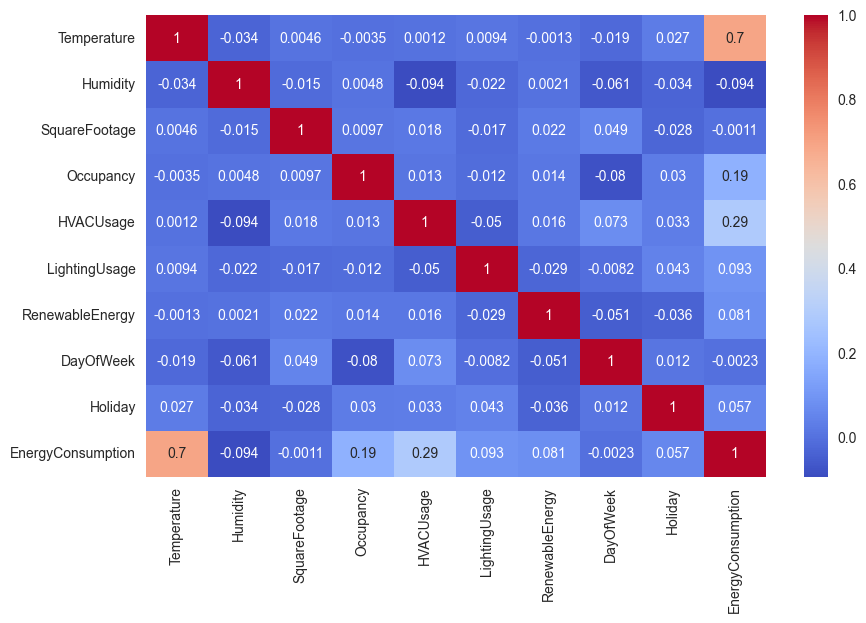

In [10]:
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.show()


División y normalización del conjunto de datos

In [11]:
# Seperamos los datos de la variable target
X = df.drop('EnergyConsumption', axis=1)
y = df['EnergyConsumption']

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=True)

# Normalizamos los datos de entrenamiento y prueba
# Escalar los datos
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir los arrays escalados a DataFrames con nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)  # Mantiene las mismas columnas


# Tamaños de los conjuntos de entrenamiento y prueba
print("Tamaño del conjunto de entrenamiento:", X_train.shape, y_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape, y_test.shape)
df.head()

Tamaño del conjunto de entrenamiento: (750, 9) (750,)
Tamaño del conjunto de prueba: (250, 9) (250,)


,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,25.139433,43.431581,1565.693999,5,1,0,2.774699,1,0,75.364373
1,27.731651,54.225919,1411.064918,1,1,1,21.831384,2,0,83.401855
2,28.704277,58.907658,1755.715009,2,0,0,6.764672,3,0,78.270888
3,20.080469,50.371637,1452.316318,1,0,1,8.623447,6,0,56.519850
4,23.097359,51.401421,1094.130359,9,1,0,3.071969,0,0,70.811732


## 5.1 Entrenamiento del modelo de Máquina de Soporte Vectorial

In [12]:
# Creamos un diccionario con los hiperparámetros que queremos probar
param_grid = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__kernel': ['linear', 'rbf'],
    'svr__gamma': ['scale', 'auto']
}

# Creamos un pipeline con un escalador y un modelo SVM
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Escalado de características
    ('svr', svm.SVR())  # Modelo SVM para regresión
])

# GridSearchCV utiliza validación cruzada (cv=5) para evaluar cada combinación de hiperparámetros
# scoring='r2' mide qué tan bien se ajusta el modelo a los datos
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Mejor modelo de SVM
best_svm_model = grid_search.best_estimator_

## 5.2 Entrenamiento del modelo de Árbol de Decisión

In [13]:
# Creamos un diccionario con los hiperparámetros que queremos probar
param_grid = {
    'max_depth': [3, 5, 10, 20, None],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['sqrt', 'log2', None],  
    'ccp_alpha': [0.0, 0.01, 0.05, 0.1] 
}

dt = tree.DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo
best_dt_model = grid_search.best_estimator_

## 6.1 Evaluación del modelo de Máquina de Soporte Vectorial

Mean Squared Error (MSE): 25.9257
Root Mean Squared Error (RMSE): 5.0917
Mean Absolute Error (MAE): 4.0945
R-squared (R²): 0.6130
Mean Absolute Percentage Error (MAPE): 5.42%


Text(0.5, 1.0, 'Consumo de energía - Real vs. Predicho - SVM')

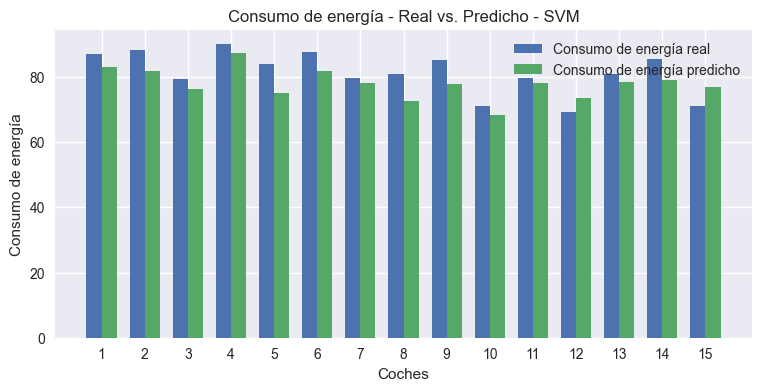

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predricción del mejor modelo de SVM
y_pred = best_svm_model.predict(X_test_scaled)

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test, y_pred)  # Error cuadrático medio: mide el error promedio al cuadrado
rmse = np.sqrt(mse)  # Raíz del error cuadrático medio: similar al MSE, pero en la misma escala que los valores originales
mae = mean_absolute_error(y_test, y_pred)  # Error absoluto medio: promedio de la diferencia absoluta entre valores reales y predichos
r2 = r2_score(y_test, y_pred)  # Coeficiente de determinación: mide qué tan bien el modelo explica los datos (1 es ajuste perfecto)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # Error absoluto medio porcentual: expresa el error en porcentaje

# Mostrar resultados
print(f"Mean Squared Error (MSE): {mse:.4f}")  # Mientras más bajo, mejor
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Similar a MSE, pero más interpretable
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Menos sensible a valores extremos que MSE
print(f"R-squared (R²): {r2:.4f}")  # Valores cercanos a 1 indican mejor ajuste
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")  # Expresa el error en porcentaje, útil para comparar modelos


ind = np.arange(15)
width = 0.35

plt.figure(figsize=(9,4))
plt.bar(ind, y_test[:15], width, label='Consumo de energía real')
plt.bar(ind+width, y_pred[:15], width, label='Consumo de energía predicho')

plt.xticks(ind+width/2, np.arange(1, 16))
plt.legend(loc='best')

plt.xlabel('Coches')
plt.ylabel('Consumo de energía')
plt.title('Consumo de energía - Real vs. Predicho - SVM')

Como vemos en los resultados predichos no son exactos, pero se acercan a los valores reales.

## 6.2 Evaluación del modelo de Árbol de Decisión

Mean Squared Error (MSE): 117.9647
Root Mean Squared Error (RMSE): 10.8612
Mean Absolute Error (MAE): 9.0274
R-squared (R²): -0.7609
Mean Absolute Percentage Error (MAPE): 11.17%


Text(0.5, 1.0, 'Consumo de energía - Real vs. Predicho - Decision Tree')

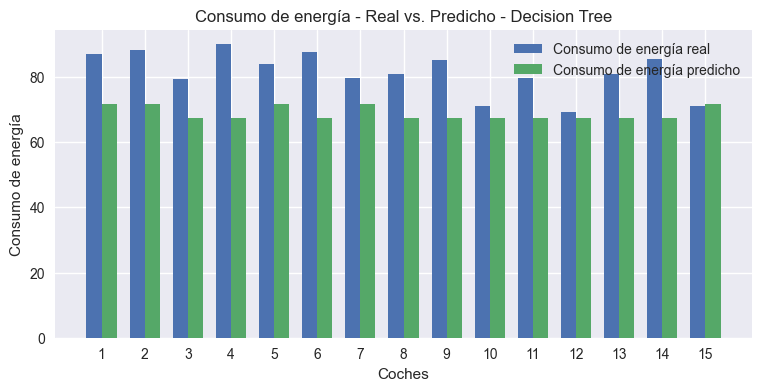

In [15]:
# 6. Evaluar el modelo con el mejor conjunto de hiperparámetros
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predricción del mejor modelo de SVM
y_pred = best_dt_model.predict(X_test_scaled)

# Calcular las métricas de evaluación
mse = mean_squared_error(y_test, y_pred)  # Error cuadrático medio: mide el error promedio al cuadrado
rmse = np.sqrt(mse)  # Raíz del error cuadrático medio: similar al MSE, pero en la misma escala que los valores originales
mae = mean_absolute_error(y_test, y_pred)  # Error absoluto medio: promedio de la diferencia absoluta entre valores reales y predichos
r2 = r2_score(y_test, y_pred)  # Coeficiente de determinación: mide qué tan bien el modelo explica los datos (1 es ajuste perfecto)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # Error absoluto medio porcentual: expresa el error en porcentaje

# Mostrar resultados
print(f"Mean Squared Error (MSE): {mse:.4f}")  # Mientras más bajo, mejor
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")  # Similar a MSE, pero más interpretable
print(f"Mean Absolute Error (MAE): {mae:.4f}")  # Menos sensible a valores extremos que MSE
print(f"R-squared (R²): {r2:.4f}")  # Valores cercanos a 1 indican mejor ajuste
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")  # Expresa el error en porcentaje, útil para comparar modelos

ind = np.arange(15)
width = 0.35

plt.figure(figsize=(9,4))
plt.bar(ind, y_test[:15], width, label='Consumo de energía real')
plt.bar(ind+width, y_pred[:15], width, label='Consumo de energía predicho')

plt.xticks(ind+width/2, np.arange(1, 16))
plt.legend(loc='best')

plt.xlabel('Coches')
plt.ylabel('Consumo de energía')
plt.title('Consumo de energía - Real vs. Predicho - Decision Tree')



En este caso, los valores predichos se alejan más de los reales. Para este conjunto de datos funciona mejor la SVM.

## 7. Serialización de los modelos

In [16]:
dv = DictVectorizer(sparse=False)
# Vectorización los datos sin la variable objetivo
dv.fit(df.drop(columns=["EnergyConsumption"]).to_dict(orient="records"))

# Modelo SVM serializado
with open('../models/svm-energy-consumption-model.pck', 'wb') as f:
    pickle.dump((dv, best_svm_model), f)
    
# Modelo Decision Tree serializado
with open('../models/dt-energy-consumption-model.pck', 'wb') as f:
    pickle.dump((dv, best_dt_model), f)